# Ejercicio 4: Entrenamiento de redes neuronales
  ##     Agustín Jofré Millet

## 1. Función de coste

In [2]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt 
import scipy.optimize as opt
from sklearn.preprocessing import PolynomialFeatures
from scipy.io import loadmat

from checkNNGradients import checkNNGradients
from displayData import displayData

num_entradas = 400   # Cada matriz de 20x20 400 componentes 
num_ocultas = 25   # 25 en la capa oculta y 10 en la capa de salida.
num_etiquetas = 10   # 10 etiquetas, desde 1 a 10 , asignando 0 a la 10



data = loadmat('ex4data1.mat')

# se pueden consultar las claves con data . keys ()
y = data['y'].ravel()  # matriz aplanada (vector)
X = data['X']

print (data)
m = len(X)

weights = loadmat('ex4weights.mat')
theta1 , theta2 = weights ['Theta1'] , weights ['Theta2' ] 
# Theta1 es de dimensión 25 x 401
# Theta2 es de dimensión 10 x 26

# Unrolling parameters
params_rn = np.hstack((theta1.flatten(), theta2.flatten()))

print ("X", X.shape)
print (y.shape)
print (theta1.shape, theta2.shape)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011', '__version__': '1.0', '__globals__': [], 'X': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'y': array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]], dtype=uint8)}
X (5000, 400)
(5000,)
(25, 401) (10, 26)


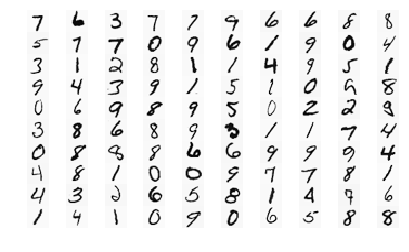

In [3]:
# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

fig, ax = displayData(sel)

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_prima(z):
    """calculo de la derivada  de la fincion sigmoide"""
    return sigmoid(z) * (1 - sigmoid(z))

### Retro-propagacion

In [5]:
def backprop(params_rn, num_entradas, num_ocultas, num_etiquetas, X, y, reg):
    
    theta1 = np.reshape(params_rn[:num_ocultas * (num_entradas + 1)], (num_ocultas , (num_entradas + 1)))
    theta2 = np.reshape(params_rn[num_ocultas * (num_entradas + 1):] ,(num_etiquetas , (num_ocultas + 1)))
    
    m = len(X)

    
    theta1_s = np.square(theta1[:,1:])
    theta2_s = np.square(theta2[:,1:])
    
    
    X = np.hstack((np.ones((X.shape[0], 1)), X))#añado unos a la col 0, shape 5000,401
    #print(X.shape)
    #print (theta1.shape)
    #print (theta2.shape)
    
    
    z2 = np.dot(X, theta1.T)
    a2 = sigmoid(z2) 
    a2 = np.hstack((np.ones((X.shape[0], 1)), a2)) #añado col de unos
    
    z3 = np.dot(a2, theta2.T)
    a3 = sigmoid(z3)
    
    Y = np.zeros((m,num_etiquetas))
    for i in range(m):
        Y[i, y[i]-1] = 1
        
    J = 0
   
    for i in range(m):
        J += -(np.sum(np.dot(Y[i,] , np.log(a3[i,])) + np.dot((1- Y[i,]) , np.log(1- a3[i,]))) / m) 
    #print (J)
    J += reg/(2*m) * (np.sum(theta1_s) + np.sum(theta2_s))
    #g= (np.dot(X.T, (hipTX -y)) + l * thetaSinCero) / m 
    
    
    ##CALCULO DEL GRADIENTE RETRO-PROPAGACION
    d3 = a3 - Y
    D2 = np.dot(d3.T, a2)
    
    z2 = np.hstack((np.ones((X.shape[0], 1)), z2))
    d2 = np.dot(d3, theta2) * sigmoid_prima(z2)
    d2 = d2[:, 1:]
    D1 = np.dot(d2.T, X)
    
    theta1Grad = 1.0 * D1 / m
    theta1Grad[:, 1:] = theta1Grad[:, 1:] + 1.0 * reg / m * theta1[:, 1:]
    
    theta2Grad = 1.0 * D2 / m
    theta2Grad[:, 1:] = theta2Grad[:, 1:] + 1.0 * reg / m * theta2[:, 1:]

    #grad = np.hstack((theta1Grad.ravel(), theta2Grad.ravel()))
    grad = np.concatenate([theta1Grad.ravel(), theta2Grad.ravel()])
    
    return J, grad

### Coste sin regularizar y regularizado

In [6]:
cost1, grad1 = backprop(params_rn, num_entradas, num_ocultas, num_etiquetas, X, y,0.0)
costReg, grad2 = backprop(params_rn, num_entradas, num_ocultas, num_etiquetas, X, y,1.0)
print ("coste 1 con lambda = 0: ", cost1)
print ("coste 1 con lambda = 1 regularizado: ", costReg)

coste 1 con lambda = 0:  0.28762916516131876
coste 1 con lambda = 1 regularizado:  0.3837698590909235


### Inicializacion de pesos aleatorios

In [7]:
def pesosAleatorios (L_in , L_out):
    epsilon_init = 0.12
    
    return np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init

In [8]:
initial_theta_1 = pesosAleatorios(num_entradas, num_ocultas)
initial_theta_2 = pesosAleatorios(num_ocultas, num_etiquetas)
initial_params_rn = np.hstack((initial_theta_1.ravel(), initial_theta_2.ravel()))
print(initial_params_rn)

[-0.00539046 -0.0735545   0.02504215 ...  0.06387753  0.0810409
 -0.04198285]


### 2.2. Chequeo del gradiente

In [9]:
reg = 3
checkNNGradients(backprop, reg)
J , _ = backprop(params_rn, num_entradas, num_ocultas, num_etiquetas, X, y,3)
print (J,checkNNGradients(backprop, reg))


0.5760512469501329 [ 4.88771523e-11  2.45914400e-13  6.90170143e-12  3.49909407e-11
 -6.05880346e-11 -7.20201676e-13 -1.52254875e-11 -4.50202098e-11
 -8.84866069e-11  5.73902037e-12 -3.67684772e-11 -1.24617872e-10
 -3.31961542e-11  6.75437484e-12 -1.07314158e-11 -2.94422264e-11
  2.88099891e-11  1.46993528e-12  1.90355995e-11  4.22846202e-11
  6.03759820e-11  1.54888879e-11  9.82969262e-12  8.85991280e-12
  2.05380990e-11  1.63342673e-11  7.24615923e-11  1.64646075e-11
  7.00067782e-12  1.21235244e-11  2.36544118e-11  2.48203680e-11
  7.23814064e-11  1.45634615e-11  6.18925744e-12  2.08569828e-11
  1.89633864e-11  1.64208924e-11]


### 3. Aprendizaje de los parámetros

In [10]:
reg = 1
options={'maxiter': 70}
res = opt.minimize (backprop, initial_params_rn, 
                    args=(num_entradas, num_ocultas, 
                    num_etiquetas, X, y,reg),method = 'TNC',
                    jac=True, options=options )
param_en = res.x

#theta1 y theta de params_rn
Theta1 = np.reshape(param_en[:num_ocultas * (num_entradas + 1)],
                    (num_ocultas, (num_entradas + 1)))

Theta2 = np.reshape(param_en[(num_ocultas * (num_entradas + 1)):],
                    (num_etiquetas, (num_ocultas + 1)))

(25, 400)


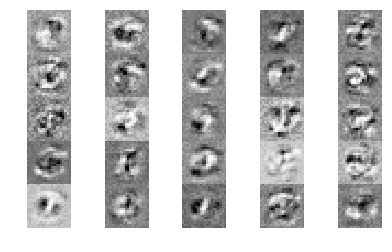

In [11]:
print(Theta1[:, 1:].shape)
fig, ax = displayData(Theta1[:, 1:])

In [12]:
def modelo(theta1, theta2, X):
    X = np.hstack((np.ones((X.shape[0], 1)), X))#añado unos a la col 0, shape 5000,401
    a1 = sigmoid(np.dot(X, theta1.T)) #calculo a1
    a1 = np.hstack((np.ones((X.shape[0], 1)), a1)) #añado col de unos
    
    a2 = sigmoid(np.dot(a1, theta2.T))

    p = np.argmax(a2, axis=1)#índices de los valores máximos del eje 1
    p += 1 #los indices arrancan desde 1 no desde cero
  
    return p

In [13]:
p = modelo (Theta1, Theta2, X )
print (p.shape)
print(y)
print ("Prediccion de :", np.mean(p == y)* 100)

(5000,)
[10 10 10 ...  9  9  9]
Prediccion de : 94.44
